In [3]:
import pandas as pd
from os import listdir
from os.path import isfile, join

raw_data_path = '../raw_data/'
logfiles = [f for f in listdir(raw_data_path) if isfile(join(raw_data_path, f))]
print(logfiles)

col_map = {
    'Time (sec)': 'time',
    'A/F Sens 1 Ratio (AFR)': 'afr',
    'AF Sens 1 Ratio (AFR)': 'afr',
    'Boost (PSI)': 'boost',
    'Calculated Load (g/rev)': 'load',
    'Feedback Knock (°)': 'feedback_knock',
    'Fine Knock Learn (°)': 'fine_knock_learn',
    'Gear Position (Gear)': 'gear_position',
    'Ignition Timing (°)': 'timing',
    'MAF (g/s)': 'maf',
    'Primary Ign. (°)': 'primary_timing',
    'RPM (RPM)': 'rpm',
    'TD Burst (%)': 'td_burst',
    'TD Continuous (%)': 'td_continuous',
    'Target Boost (PSI)': 'boost_target',
    'Throttle Pos. (%)': 'throttle',
    'Wastegate Duty (%)': 'wg_duty',
    'Wastegate Max (%)': 'wg_max',
}
dataframes = []

for log in logfiles:
    #print( log )
    # read the logfile
    data = pd.read_csv('../raw_data/{}'.format(log), encoding='iso-8859-1')
    
    #print(data.columns)
    # drop the metadata column:
    data.drop(data.columns[[-1]], axis=1, inplace=True)

    # rename the columns
    data.rename(columns=col_map, inplace=True)
    
    # change delta_t to timestamps
    start_time = pd.Timestamp(log.split('.')[1])
    delta_t = pd.to_timedelta(data['time'], unit='s')
    data['time'] = delta_t + start_time

    # and set the timestamps as the index
    data.index = data.time
    data.drop('time', 1, inplace=True)
                              
    dataframes.append(data)
    
    
# Concatenate all the dataframes together, 
# easier because they are in a list already

data = pd.concat(dataframes)
data.describe()

['roxy_log.201607270830.csv', 'roxy_log.201607210800.csv', 'roxy_log.201607211200.csv', 'roxy_log.201607251200.csv', 'roxy_log.201607251500.csv', 'roxy_log.201607250900.csv', 'roxy_log.201607220800.csv']


,afr,boost,load,feedback_knock,fine_knock_learn,gear_position,timing,maf,primary_timing,rpm,td_burst,td_continuous,boost_target,throttle,wg_duty,wg_max
count,122771.000000,122771.000000,122771.000000,122771.000000,122771.000000,122771.000000,122771.000000,122771.000000,122771.00000,122771.000000,122771.000000,122771.000000,122771.000000,122771.000000,122771.000000,122771.000000
mean,15.763771,-7.788969,0.447695,-0.001839,-0.045493,3.207142,25.057648,18.257983,25.31573,2138.628129,-0.002819,4.263650,-4.354385,7.744190,10.533924,13.521492
std,3.405033,4.374453,0.371791,0.063418,0.265957,1.870825,11.902890,25.787123,12.54263,1056.117063,0.175675,1.482822,3.738674,14.313448,14.066344,14.840890
min,11.140000,-12.470000,0.030000,-4.220000,-2.460000,1.000000,-13.500000,1.560000,5.31000,0.000000,-6.000000,-5.030000,-9.750000,0.000000,0.000000,0.000000
25%,14.360000,-10.090000,0.270000,0.000000,0.000000,1.000000,11.500000,4.350000,11.99000,941.000000,0.000000,4.210000,-5.410000,0.000000,0.000000,0.000000
50%,14.590000,-8.910000,0.330000,0.000000,0.000000,3.000000,25.500000,10.040000,26.76000,2322.000000,0.000000,5.000000,-5.340000,4.000000,0.000000,4.720000
75%,14.810000,-7.150000,0.520000,0.000000,0.000000,5.000000,37.000000,22.220000,38.36000,2901.000000,0.000000,5.000000,-5.340000,11.000000,25.490000,30.850000
max,25.730000,18.760000,2.940000,0.000000,0.000000,6.000000,43.500000,248.790000,42.58000,6880.000000,5.000000,5.000000,19.840000,100.000000,45.490000,45.680000


In [4]:
import datashader as ds
import datashader.glyphs
import datashader.transfer_functions as tf

CPU times: user 276 ms, sys: 0 ns, total: 276 ms
Wall time: 275 ms


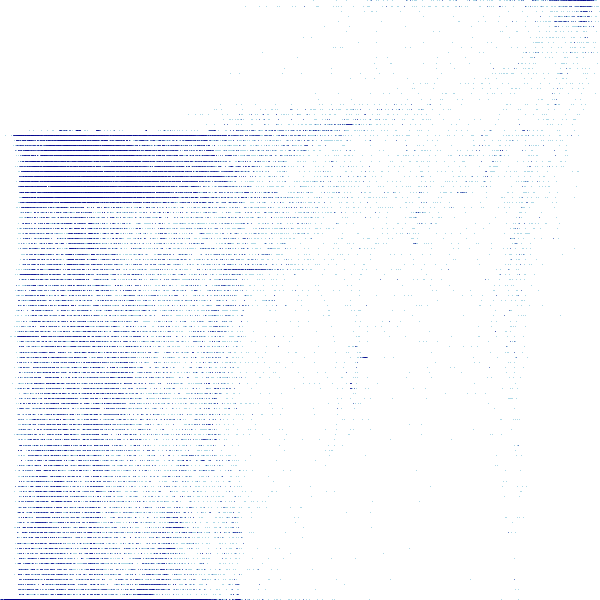

In [5]:
%time tf.interpolate(ds.Canvas().points(data,'boost', 'wg_duty'))

## Choose a glyph, which determines how an incoming datapoint maps onto the rectangular grid.

In [34]:
x = "wg_duty" #"boost"
y = "boost" #"wg_duty"

glyph = ds.glyphs.Point(x, y)



## Decide what size final image you want (in pixels), and what range of the data to plot

In [35]:
canvas = ds.Canvas(
    plot_width=200, 
    plot_height=200, 
    #x_range=(-8,8), 
    #y_range=(-8,8)
)

In [36]:
from datashader import reductions
reduction = reductions.count()

from datashader.core import bypixel
agg = bypixel(data, canvas, glyph, reduction)
agg

<xarray.DataArray (y_axis: 200, x_axis: 200)>
array([[ 21,   0,   0, ...,   0,   0,   0],
       [ 64,   0,   0, ...,   0,   0,   0],
       [166,   0,   0, ...,   0,   0,   0],
       ..., 
       [  0,   0,   0, ...,   1,   0,   7],
       [  0,   0,   0, ...,   3,   0,   1],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=int32)
Coordinates:
  * y_axis   (y_axis) float64 -12.47 -12.31 -12.16 -12.0 -11.84 -11.69 ...
  * x_axis   (x_axis) float64 0.0 0.2286 0.4572 0.6858 0.9144 1.143 1.372 ...

In [37]:
cp = canvas.points(data, x, y, agg=reductions.count())

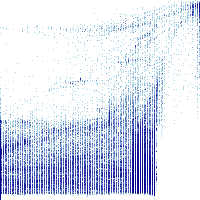

In [38]:
tf.interpolate(cp)

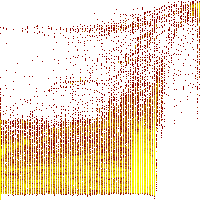

In [39]:
# Heatmap coloration via cmap argument
tf.interpolate(agg, cmap=["darkred", "yellow"])

In [40]:
from bokeh.palettes import RdBu9
tf.interpolate(agg,cmap=RdBu9)
color_key = RdBu9

## Embedding in Bokeh

In [41]:
import bokeh.plotting as bp
from datashader.bokeh_ext import InteractiveImage

bp.output_notebook()
p = bp.figure(
    tools='pan,wheel_zoom,reset', 
    x_range=(0,20), 
    y_range=(0,50)
)

def image_callback(x_range, y_range, w, h):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(data, x, y, ds.count())#ds.count_cat('throttle'))
    img = tf.interpolate(agg, cmap=color_key)
    return img #tf.dynspread(img, threshold=0.25)

InteractiveImage(p, image_callback)

Loading BokehJS ...